## Lab 2

### Part 3. Poetry generation

Let's try to generate some poetry using RNNs. 

You have several choices here: 

* The Shakespeare sonnets, file `sonnets.txt` available in the notebook directory.

* Роман в стихах "Евгений Онегин" Александра Сергеевича Пушкина. В предобработанном виде доступен по [ссылке](https://github.com/attatrol/data_sources/blob/master/onegin.txt).

* Some other text source, if it will be approved by the course staff.

Text generation can be designed in several steps:
    
1. Data loading.
2. Dictionary generation.
3. Data preprocessing.
4. Model (neural network) training.
5. Text generation (model evaluation).


In [221]:
import string
import os
import numpy as np
import torch, torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset, Subset
from IPython.display import clear_output
from matplotlib import pyplot as plt

### Data loading: Shakespeare

Shakespeare sonnets are awailable at this [link](http://www.gutenberg.org/ebooks/1041?msg=welcome_stranger). In addition, they are stored in the same directory as this notebook (`sonnetes.txt`). Simple preprocessing is already done for you in the next cell: all technical info is dropped.

In [230]:
if not os.path.exists('sonnets.txt'):
    !wget https://raw.githubusercontent.com/girafe-ai/ml-mipt/master/homeworks_basic/Lab2_DL/sonnets.txt

with open('sonnets.txt', 'r') as iofile:
    text = iofile.readlines()
    
TEXT_START = 45
TEXT_END = -368
text = text[TEXT_START : TEXT_END]
assert len(text) == 2616

In opposite to the in-class practice, this time we want to predict complex text. Let's reduce the complexity of the task and lowercase all the symbols.

Now variable `text` is a list of strings. Join all the strings into one and lowercase it.

In [231]:
# Join all the strings into one and lowercase it
# Put result into variable text.

# Your great code here
tokens = set()

for i in range(len(text)):
  text[i] = text[i].lower()
  tokens.update(set(text[i]))

tokens = list(sorted(tokens))
out = ("".join(text)).lower()

assert len(out) == 100225, 'Are you sure you have concatenated all the strings? {}'.format(len(text))
assert not any([x in set(out) for x in string.ascii_uppercase]), 'Uppercase letters are present'
print('OK!')

OK!


Create dictionary `token_to_idx = {<char>: <index>}` and dictionary `idx_to_token = {<index>: <char>}`

In [232]:
print('mean line length in symbols', np.mean(list(map(len, text))))

mean line length in symbols 38.31230886850153


In [233]:
class ShakeSpearDataset:
  def __init__(self, txt, tokens, max_sequence_length=3*38, min_sequence_length=3):
    self.tokens = tokens
    self.txt = txt
    self.max_sequence_size = max_sequence_length
    self.min_sequence_size = min_sequence_length
    self.num_tokens = len(tokens)

    self.idx_to_token = {
      i : self.tokens[i] for i in range(len(self.tokens))
    }

    self.token_to_idx = {
      self.tokens[i] : i for i in range(len(self.tokens))
    }

    # self.one_hot = {
    #   self.tokens[i] : np.zeros(len(self.tokens)) for i in range(len(self.tokens))
    # }
    # for token in self.one_hot:
    #   self.one_hot[token][self.token_to_idx[token]] = 1

  def to_matrix(self, words, max_len=None , dtype='int32', batch_first=True):
    """Casts a list of words into rnn-digestable matrix"""
    
    pad=self.token_to_idx[' ']
    max_len = max_len or max(map(len, words))
    words_ix = np.zeros([len(words), max_len], dtype) + pad

    for i in range(len(words)):
        line_ix = [self.token_to_idx[c] for c in words[i]]
        words_ix[i, :len(line_ix)] = line_ix
        
    if not batch_first: # convert [batch, time] into [time, batch]
        words_ix = np.transpose(words_ix)

    return words_ix

  def get_batch(self, batch_size=32):
    words = []

    for i in range(batch_size):
       start_idx = np.random.randint(0, len(self.txt))
       shift = np.random.randint(self.min_sequence_size, self.max_sequence_size)
       words.append(self.txt[start_idx:min(start_idx+shift, len(self.txt))])

    return self.to_matrix(words)

In [234]:
dataset = ShakeSpearDataset(out, tokens)

*Comment: in this task we have only 38 different tokens, so let's use one-hot encoding.*

### Building the model

Now we want to build and train recurrent neural net which would be able to something similar to Shakespeare's poetry.

Let's use vanilla RNN, similar to the one created during the lesson.

In [235]:
device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')

device

device(type='cuda', index=0)

In [236]:
# Your code here
class CharRNNLoop(nn.Module):
  def __init__(self, num_tokens=num_tokens, emb_size=16, rnn_num_units=64):
    super(self.__class__, self).__init__()
    self.num_units = rnn_num_units

    self.emb = nn.Embedding(num_tokens, emb_size)
    self.rnn = nn.RNN(emb_size, rnn_num_units, batch_first=True)
    self.hid_to_logits = nn.Linear(rnn_num_units, num_tokens)

  def forward(self, x):
   # assert isinstance(x.data, torch.LongTensor)
    h_seq, _ = self.rnn(self.emb(x))
    next_logits = self.hid_to_logits(h_seq)
    next_logp = F.log_softmax(next_logits, dim=-1)
    return next_logp

In [237]:
BATCH_SIZE = 32

def rnn_train_loop(model, data, loss_fn, opt, max_iterations: int):
  loss_history = []
  model.train(True)

  for i in range(max_iterations):
    opt.zero_grad()
    
    batch_ix = data.get_batch(BATCH_SIZE)
    batch_ix = torch.LongTensor(batch_ix)#.to(device)
    
    logp_seq = model.forward(batch_ix)
    
    predictions_logp = logp_seq[:, :-1]
    actual_next_tokens = batch_ix[:, 1:]
    
    loss = loss_fn(
        predictions_logp.contiguous().view(-1, data.num_tokens),
        actual_next_tokens.contiguous().view(-1)
    )

    loss.backward()
    opt.step()

    loss_history.append(loss.item())
    if (i+1)%2==0:
        clear_output(True)
        plt.plot(loss_history,label='loss')
        plt.legend()
        plt.show()

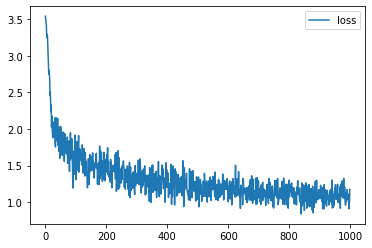

In [238]:
model = CharRNNLoop()
opt = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.NLLLoss()

rnn_train_loop(model, dataset, criterion, opt, max_iterations=1000)

Plot the loss function (axis X: number of epochs, axis Y: loss function).

In [243]:
token_to_id = dataset.token_to_idx
tokens = dataset.tokens

def generate_sample(char_rnn, seed_phrase=' hello', max_length=1000, temperature=1.0):
    '''
    ### Disclaimer: this is an example function for text generation.
    ### You can either adapt it in your code or create your own function
    
    The function generates text given a phrase of length at least SEQ_LENGTH.
    :param seed_phrase: prefix characters. The RNN is asked to continue the phrase
    :param max_length: maximum output length, including seed_phrase
    :param temperature: coefficient for sampling.  higher temperature produces more chaotic outputs, 
        smaller temperature converges to the single most likely output.
        
    Be careful with the model output. This model waits logits (not probabilities/log-probabilities)
    of the next symbol.
    '''
    
    x_sequence = [token_to_id[token] for token in seed_phrase]
    x_sequence = torch.tensor([[x_sequence]], dtype=torch.int64)
    hid_state = char_rnn.initial_state(batch_size=1)
    
    #feed the seed phrase, if any
    for i in range(len(seed_phrase) - 1):
        print(x_sequence[:, -1].shape, hid_state.shape)
        out, hid_state = char_rnn(x_sequence[:, i], hid_state)
    
    #start generating
    for _ in range(max_length - len(seed_phrase)):
        print(x_sequence.shape, x_sequence, hid_state.shape)
        out, hid_state = char_rnn(x_sequence[:, -1], hid_state)
        # Be really careful here with the model output
        p_next = F.softmax(out / temperature, dim=-1).data.numpy()[0]        
        # sample next token and push it back into x_sequence
        print(p_next.shape, len(tokens))
        next_ix = np.random.choice(len(tokens), p=p_next)
        next_ix = torch.tensor([[next_ix]], dtype=torch.int64)
        print(x_sequence.shape, next_ix.shape)
        x_sequence = torch.cat([x_sequence, next_ix], dim=1)
        
    return ''.join([tokens[ix] for ix in x_sequence.data.numpy()[0]])

In [244]:
model.train(False)
generate_sample(model)

ModuleAttributeError: ignored

### More poetic model

Let's use LSTM instead of vanilla RNN and compare the results.

Plot the loss function of the number of epochs. Does the final loss become better?

In [ ]:
# Your beautiful code here

Generate text using the trained net with different `temperature` parameter: `[0.1, 0.2, 0.5, 1.0, 2.0]`.

Evaluate the results visually, try to interpret them.

In [ ]:
# Text generation with different temperature values here

### Saving and loading models

Save the model to the disk, then load it and generate text. Examples are available [here](https://pytorch.org/tutorials/beginner/saving_loading_models.html]).

In [ ]:
# Saving and loading code here

### References
1. <a href='http://karpathy.github.io/2015/05/21/rnn-effectiveness/'> Andrew Karpathy blog post about RNN. </a> 
There are several examples of genration: Shakespeare texts, Latex formulas, Linux Sourse Code and children names.
2. <a href='https://github.com/karpathy/char-rnn'> Repo with char-rnn code </a>
3. Cool repo with PyTorch examples: [link](https://github.com/spro/practical-pytorch`)